In [1]:
# impport all necessary packages

import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import os


dataset_path = "/s/chopin/l/grad/tskumar/Documents/ESML/datasets/base_dataset/"

class_directory = os.listdir(dataset_path)
print("These are the two classes: ", class_directory[0], class_directory[1])

data_paths = {'anomaly_data_path': [], 'normal_data_path': []}

# get the path of all anomaly videos
sub_directory_path = os.path.join(dataset_path, class_directory[0])
for sub_directory in os.listdir(sub_directory_path):
    list_files = os.listdir(os.path.join(sub_directory_path, sub_directory))
    [data_paths['anomaly_data_path'].append(os.path.join(sub_directory_path, sub_directory, file)) for file in list_files]


# get the path of all normal videos
sub_directory_path = os.path.join(dataset_path, class_directory[1])
for sub_directory in os.listdir(sub_directory_path):
    list_files = os.listdir(os.path.join(sub_directory_path, sub_directory))
    [data_paths['normal_data_path'].append(os.path.join(sub_directory_path, sub_directory, file)) for file in list_files]

print("Size of anomaly data:", len(data_paths['anomaly_data_path']))
print("Size of normal data:", len(data_paths['normal_data_path']))
print('\n')

2023-11-09 18:18:01.436680: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-09 18:18:01.749146: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/python-env/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-11-09 18:18:01.749155: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


These are the two classes:  anomaly_data normal_data
Size of anomaly data: 1218
Size of normal data: 2735




In [33]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
# import remotezip as rz

import tensorflow as tf

# Some modules to display an animation using imageio.
# import imageio
from IPython import display
from urllib import request
# from tensorflow_docs.vis import embe
from pathlib import Path

In [34]:
def format_frames(frame, output_size):
    """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [4]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
    """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

### Analysing the anomaly data

2023-11-09 18:18:41.909128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/python-env/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-11-09 18:18:41.909142: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-09 18:18:41.909154: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (harrisburg): /proc/driver/nvidia/version does not exist
2023-11-09 18:18:41.914115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


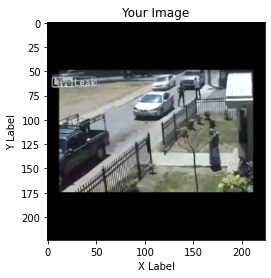

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

res = frames_from_video_file(video_path = data_paths['anomaly_data_path'][0], n_frames = 120, output_size = (224,224), frame_step = 5)
# Display the image using imshow
ax.imshow(res[0])

# You can optionally add titles or labels
ax.set_title('Your Image')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

# Show the image
plt.show()

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_extracted_frames(num_rows, num_cols, frames_array):

    # Create a Matplotlib figure and subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 16))  # Adjust figsize as needed

    # Flatten the 2D array of subplots to make it easier to iterate through
    axes = axes.flatten()

    # Iterate through the image paths and display each image on a subplot
    for count, frame in enumerate(frames_array):
        if count < num_rows * num_cols:
            # Display the image on the current subplot
            axes[count].imshow(frame)
            axes[count].set_title(f'Image {count + 1}')
            # Turn off axis labels
            axes[count].axis('off')

    # Adjust the layout for better visualization
    plt.tight_layout()

    # Show the subplots
    plt.show()

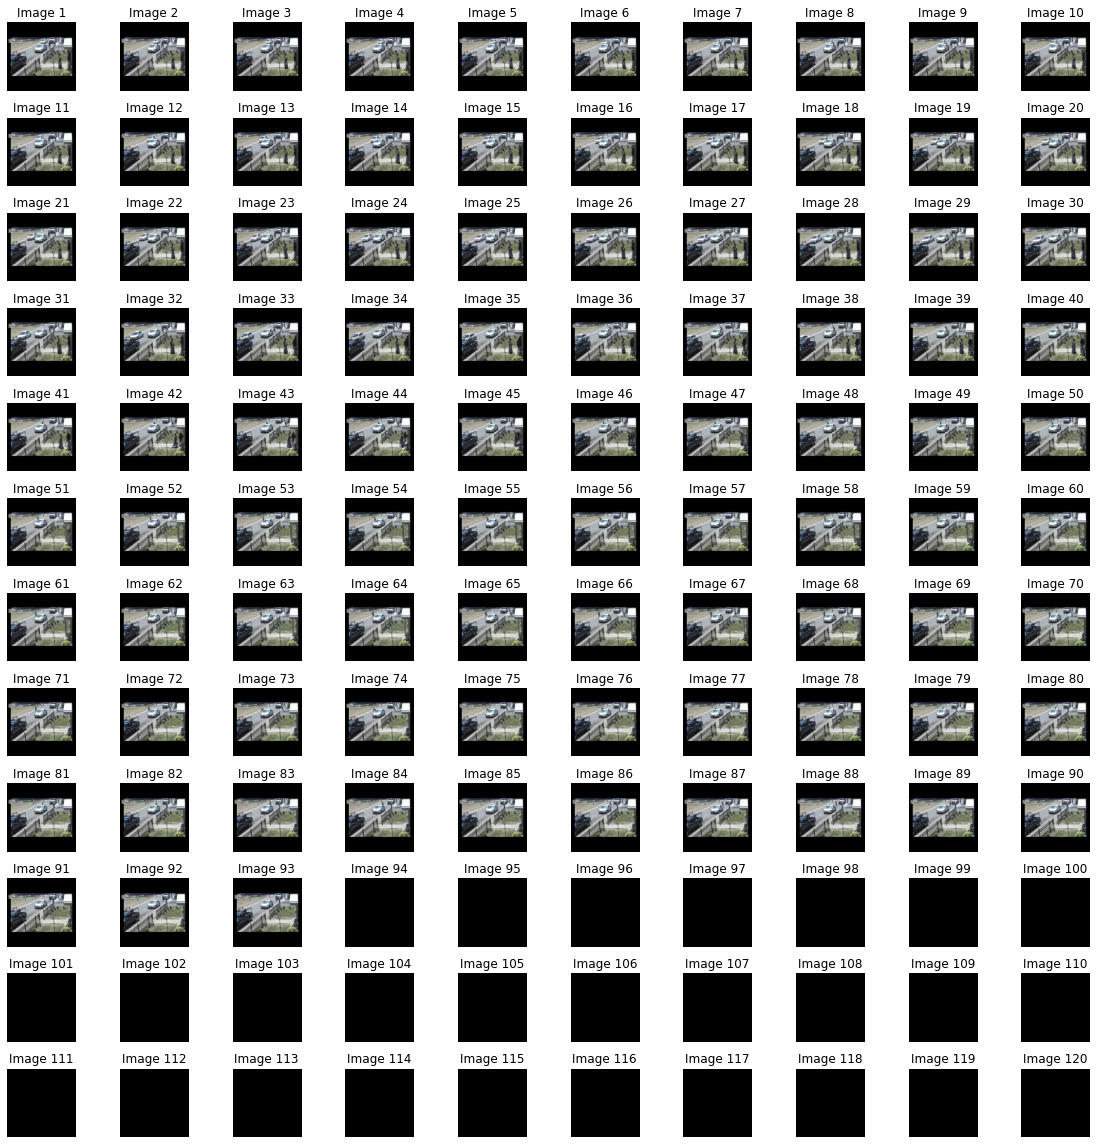

In [7]:
# Define the number of rows and columns for the subplot grid
num_rows = 12  # Adjust the number of rows and columns as needed
num_cols = 10
frames_array = frames_from_video_file(video_path = data_paths['anomaly_data_path'][0], n_frames = 120, output_size = (224,224), frame_step = 5)
display_extracted_frames(num_rows, num_cols, frames_array)

In [8]:
import cv2

def get_video_duration(video_file_path):
    try:
        # Open the video file
        cap = cv2.VideoCapture(video_file_path)

        # Get the frame count and frames per second (FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))

        # Calculate the duration in seconds
        duration = frame_count / fps

        # Release the video capture object
        cap.release()

        return duration
    except Exception as e:
        print(f"Error: {e}")
        return None

def get_all_video_duration(videos_path):
    stats_of_video_data = []
    for video_file_path in videos_path:
        duration = get_video_duration(video_file_path)
        if duration is not None:
            stats_of_video_data.append((video_file_path, duration))
    return stats_of_video_data

In [9]:
stats_of_video_data = get_all_video_duration(videos_path = data_paths['anomaly_data_path'])

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac9647580] moov atom not found


Error: division by zero
Error: division by zero


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac967afc0] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac967afc0] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac967afc0] moov atom not found


Error: division by zero
Error: division by zero
Error: division by zero
Error: division by zero
Error: division by zero


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac967afc0] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac967afc0] moov atom not found


Error: division by zero
Error: division by zero


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac967afc0] moov atom not found


Error: division by zero
Error: division by zero


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac967afc0] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac967afc0] moov atom not found


Error: division by zero
Error: division by zero
Error: division by zero


In [10]:
print(len(stats_of_video_data))
print(len(data_paths['anomaly_data_path']))

1204
1218


In [11]:
# Separate the pairs into two arrays
second_values = [round(pair[1]) for pair in stats_of_video_data]

In [12]:
def count_videos_in_duration_range(second_values, min_value, max_value):
    count = np.sum(np.logical_and(second_values > min_value, second_values < max_value))
    return count

In [13]:
count_videos_in_duration_range(np.array(second_values), min_value = 0, max_value = 100)

997

In [14]:
count_videos_in_duration_range(np.array(second_values), min_value = 100, max_value = 200)

124

In [15]:
for idx in range(20):
    min_value = idx*100
    max_value = idx*100 + 100
    print("num of videos in range of {} - {}: {}".format(min_value, max_value, count_videos_in_duration_range(np.array(second_values), min_value = min_value, max_value = max_value)))

num of videos in range of 0 - 100: 997
num of videos in range of 100 - 200: 124
num of videos in range of 200 - 300: 34
num of videos in range of 300 - 400: 20
num of videos in range of 400 - 500: 12
num of videos in range of 500 - 600: 5
num of videos in range of 600 - 700: 3
num of videos in range of 700 - 800: 3
num of videos in range of 800 - 900: 0
num of videos in range of 900 - 1000: 0
num of videos in range of 1000 - 1100: 0
num of videos in range of 1100 - 1200: 0
num of videos in range of 1200 - 1300: 0
num of videos in range of 1300 - 1400: 1
num of videos in range of 1400 - 1500: 0
num of videos in range of 1500 - 1600: 0
num of videos in range of 1600 - 1700: 1
num of videos in range of 1700 - 1800: 0
num of videos in range of 1800 - 1900: 0
num of videos in range of 1900 - 2000: 0


shorter duration video: 1
longer duration video: 4218


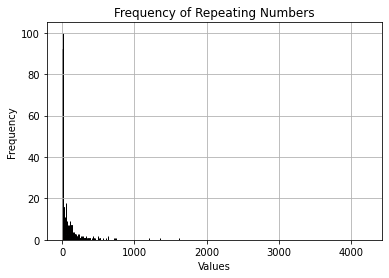

In [16]:
min_value = min(second_values)
max_value = max(second_values)
print("shorter duration video:", min_value)
print("longer duration video:", max_value)

# Create a histogram
plt.hist(second_values, bins=np.arange(min_value, max_value), edgecolor='k')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Frequency of Repeating Numbers')
plt.grid(True)

# Show the histogram
plt.show()

shorter duration video: 1
longer duration video: 4218


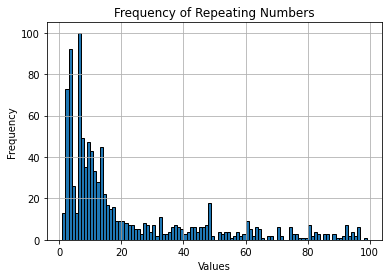

In [17]:
min_value = min(second_values)
max_value = max(second_values)
print("shorter duration video:", min_value)
print("longer duration video:", max_value)

# Create a histogram
plt.hist(second_values, bins=np.arange(min_value, 100), edgecolor='k')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Frequency of Repeating Numbers')
plt.grid(True)

# Show the histogram
plt.show()

### Analysing the normal data

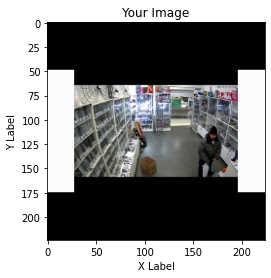

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

res_normal = frames_from_video_file(video_path = data_paths['normal_data_path'][5], n_frames = 120, output_size = (224,224), frame_step = 5)
# Display the image using imshow
ax.imshow(res_normal[0])

# You can optionally add titles or labels
ax.set_title('Your Image')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

# Show the image
plt.show()

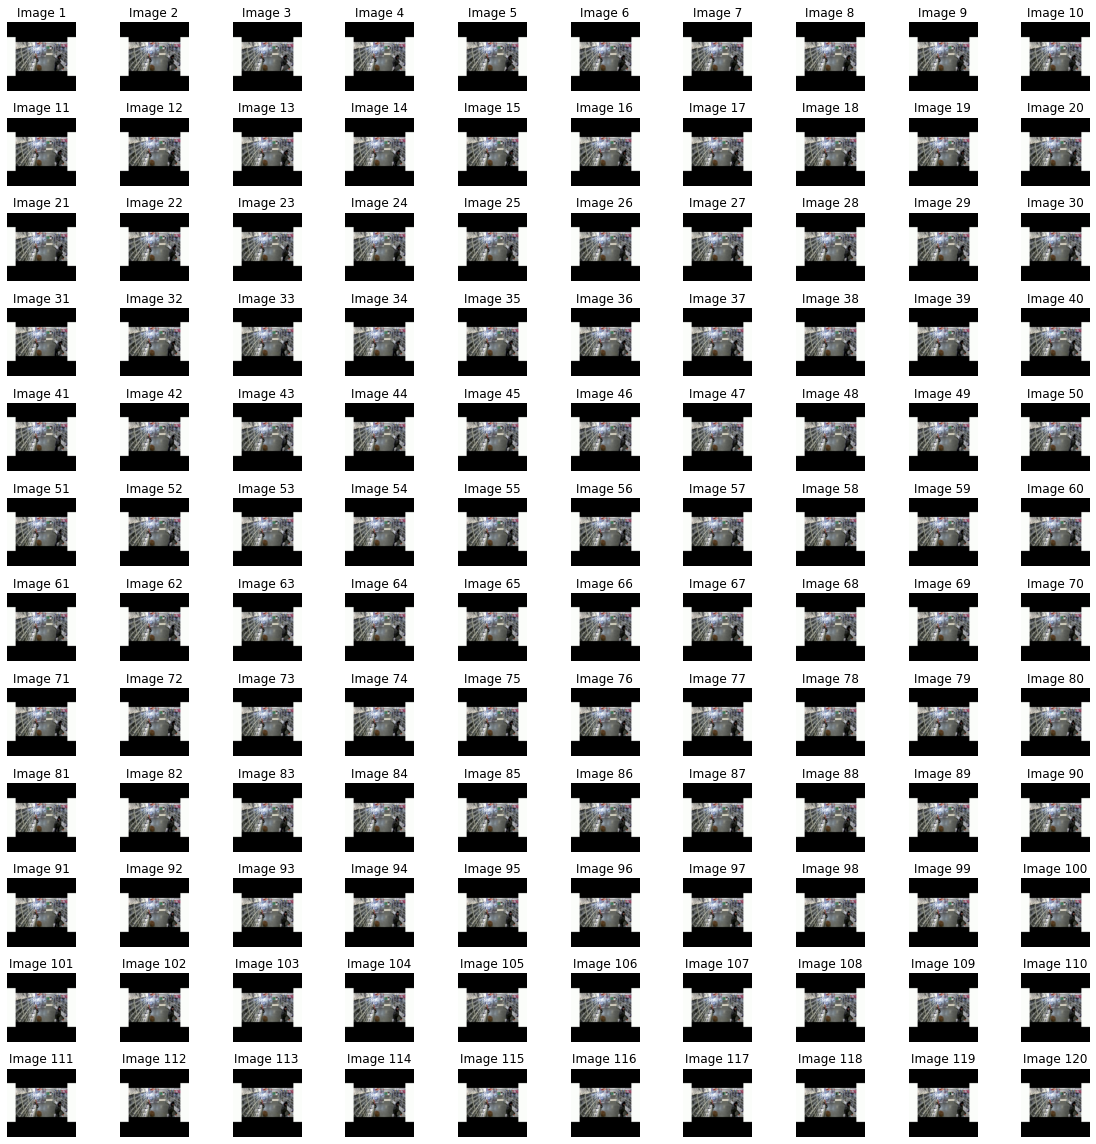

In [19]:
# Define the number of rows and columns for the subplot grid
num_rows = 12  # Adjust the number of rows and columns as needed
num_cols = 10
frames_array = frames_from_video_file(video_path = data_paths['normal_data_path'][5], n_frames = 120, output_size = (224,224), frame_step = 5)
display_extracted_frames(num_rows, num_cols, frames_array)

In [20]:
stats_of_normal_video_data = get_all_video_duration(videos_path = data_paths['normal_data_path'])

Error: division by zero


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac99af700] moov atom not found


Error: division by zero


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac9ba8ac0] moov atom not found


Error: division by zero


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac9ba8ac0] moov atom not found


Error: division by zero
Error: division by zero


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac9ba8ac0] moov atom not found


Error: division by zero
Error: division by zero
Error: division by zero
Error: division by zero
Error: division by zero


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac9b6bf80] moov atom not found


Error: division by zero
Error: division by zero
Error: division by zero
Error: division by zero


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac9b77c00] moov atom not found


Error: division by zero


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac718db40] moov atom not found


Error: division by zero
Error: division by zero
Error: division by zero
Error: division by zero


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac9ba8ac0] moov atom not found


Error: division by zero
Error: division by zero


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac9ba8ac0] moov atom not found


Error: division by zero
Error: division by zero
Error: division by zero


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x559ac9ba8ac0] moov atom not found


Error: division by zero


In [21]:
print(len(stats_of_normal_video_data))
print(len(data_paths['normal_data_path']))

2710
2735


In [22]:
# Separate the pairs into two arrays
second_values = [round(pair[1]) for pair in stats_of_normal_video_data]

In [23]:
for idx in range(20):
    min_value = idx*100
    max_value = idx*100 + 100
    print("num of videos in range of {} - {}: {}".format(min_value, max_value, count_videos_in_duration_range(np.array(second_values), min_value = min_value, max_value = max_value)))

num of videos in range of 0 - 100: 2380
num of videos in range of 100 - 200: 120
num of videos in range of 200 - 300: 50
num of videos in range of 300 - 400: 15
num of videos in range of 400 - 500: 5
num of videos in range of 500 - 600: 18
num of videos in range of 600 - 700: 5
num of videos in range of 700 - 800: 7
num of videos in range of 800 - 900: 9
num of videos in range of 900 - 1000: 4
num of videos in range of 1000 - 1100: 7
num of videos in range of 1100 - 1200: 3
num of videos in range of 1200 - 1300: 6
num of videos in range of 1300 - 1400: 4
num of videos in range of 1400 - 1500: 2
num of videos in range of 1500 - 1600: 0
num of videos in range of 1600 - 1700: 4
num of videos in range of 1700 - 1800: 3
num of videos in range of 1800 - 1900: 0
num of videos in range of 1900 - 2000: 2


shorter duration video: 0
longer duration video: 6416


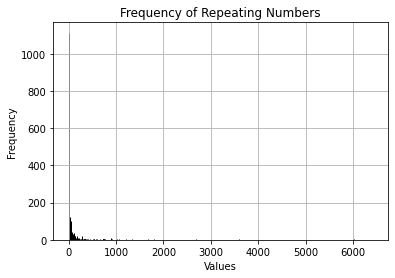

In [24]:
min_value = min(second_values)
max_value = max(second_values)
print("shorter duration video:", min_value)
print("longer duration video:", max_value)

# Create a histogram
plt.hist(second_values, bins=np.arange(min_value, max_value), edgecolor='k')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Frequency of Repeating Numbers')
plt.grid(True)

# Show the histogram
plt.show()

shorter duration video: 0
longer duration video: 6416


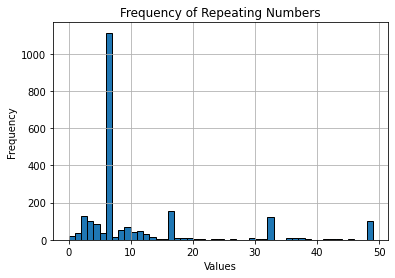

In [27]:
min_value = min(second_values)
max_value = max(second_values)
print("shorter duration video:", min_value)
print("longer duration video:", max_value)

# Create a histogram
plt.hist(second_values, bins=np.arange(min_value, 50), edgecolor='k')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Frequency of Repeating Numbers')
plt.grid(True)

# Show the histogram
plt.show()